# Image Segmentation by Supervised Learning

## import libraries

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [34]:
directory_data  = './'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (600, 128, 128)
size of y_train : (600, 128, 128)
*************************************************
size of x_test : (400, 128, 128)
size of y_test : (400, 128, 128)
*************************************************
number of training image : 600
height of training image : 128
width of training image : 128
*************************************************
number of testing image : 400
height of testing image : 128
width of testing image : 128
*************************************************


## hyper-parameters

In [35]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 500
size_minibatch  = 50
learning_rate   = 0.05
weight_decay    = 0.009

## custom data loader for the PyTorch framework

In [36]:
class dataset(Dataset):
    
    def __init__(self, image, label, transform=0):
        
        self.image  = image
        self.label  = label 
        self.transform = transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        label   = self.label[index]
        
        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.FloatTensor(label).unsqueeze(dim=0)

        image   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('bilinear'))(image)
        label   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('nearest'))(label)

        if self.transform == 1:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,2])
            label = torch.flip(label, [0,2])
            
            #
            # ==================================================

        if self.transform == 2:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,1])
            label = torch.flip(label, [0,1])
            
            #
            # ==================================================
        return (image, label)
    
    def __len__(self):
        
        return self.image.shape[0]

## construct datasets and dataloaders for training and testing

In [37]:
dataset_train_transform = dataset(x_train, y_train, transform=1)
dataset_train_transform_ud = dataset(x_train, y_train, transform=2)
dataset_train           = dataset(x_train, y_train)
dataset_test            = dataset(x_test, y_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train_transform_ud  = DataLoader(dataset_train_transform_ud, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 64, 64])
shape of the label in the training dataset: torch.Size([1, 64, 64])


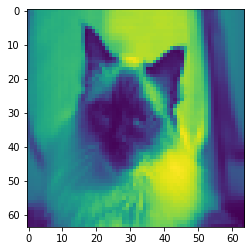

*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 64, 64])
shape of the label in the testing dataset: torch.Size([1, 64, 64])
*******************************************************************
shape of the image in the training transform dataset: torch.Size([1, 64, 64])
shape of the label in the training transform dataset: torch.Size([1, 64, 64])


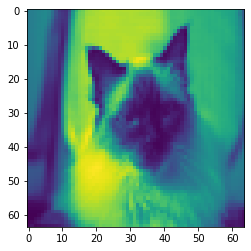

*******************************************************************


In [38]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
(image_train_transform, label_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
plt.imshow(image_train[0], interpolation='nearest')
plt.show()
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')
print('shape of the image in the training transform dataset:', image_train_transform.shape)
print('shape of the label in the training transform dataset:', label_train_transform.shape)
plt.imshow(image_train_transform[0], interpolation='nearest')
plt.show()
print('*******************************************************************')

## class for the neural network 

In [39]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # self.activation		= nn.ReLU(inplace=True)
        self.activation		= nn.LeakyReLU(0.1)
        self.activation_out	= nn.Sigmoid()
        self.skip = nn.Identity()
      
        self.mp = nn.MaxPool2d(2,2)
        self.us = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv_e1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e1.weight)
        self.ebn1 = nn.BatchNorm2d(16)

        self.conv_e2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e2.weight)
        self.ebn2 = nn.BatchNorm2d(32)

        self.conv_e3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e3.weight)
        self.ebn3 = nn.BatchNorm2d(64)

        self.conv_e4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e4.weight)
        self.ebn4 = nn.BatchNorm2d(128)

        self.conv_e5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e5.weight)
        self.ebn5 = nn.BatchNorm2d(256)

        self.conv_e6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e6.weight)
        self.ebn6  = nn.BatchNorm2d(512)

        self.conv_e7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_e7.weight)
        self.ebn7  = nn.BatchNorm2d(512)



        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.conv_d1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d1.weight)
        self.dbn1 = nn.BatchNorm2d(256)

        self.conv_d2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d2.weight)
        self.dbn2 = nn.BatchNorm2d(128)

        self.conv_d3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d3.weight)
        self.dbn3 = nn.BatchNorm2d(64)
        nn.ReLU(),

        self.conv_d4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d4.weight)
        self.dbn4 = nn.BatchNorm2d(32)

        self.conv_d5 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d5.weight)
        self.dbn5 = nn.BatchNorm2d(16)

        self.conv_d6 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        nn.init.xavier_uniform_(self.conv_d6.weight)

    def forward(self,x):
        out = self.conv_e1(x)
        out = self.ebn1(out)
        out = self.activation(out)
        out = self.mp(out)
        # res1 = out

        out = self.conv_e2(out)
        out = self.ebn2(out)
        out = self.activation(out)
        res2 = out

        out = self.conv_e3(out)
        out = self.ebn3(out)
        out = self.activation(out)
        res3 = out

        out = self.conv_e4(out)
        out = self.ebn4(out)
        out = self.activation(out)
        res4 = out

        out = self.conv_e5(out)
        out = self.ebn5(out)
        out = self.activation(out)
        out = self.mp(out)
        res5 = out

        out = self.conv_e6(out)
        out = self.ebn6(out)
        out = self.activation(out)
        out = self.mp(out)
        res6 = out

        out = self.conv_e7(out)
        out = self.ebn7(out)
        out = self.activation(out)
        

        out = self.us(out)
        out = self.conv_d1(out)
        out = self.dbn1(out)
        out = self.activation(out)
        out = out + self.skip(res5)

        out = self.us(out)
        out = self.conv_d2(out)
        out = self.dbn2(out)
        out = self.activation(out)
        out = out + self.skip(res4)

        out = self.conv_d3(out)
        out = self.dbn3(out)
        out = self.activation(out)
        out = out + self.skip(res3)

        out = self.conv_d4(out)
        out = self.dbn4(out)
        out = self.activation(out)
        out = out + self.skip(res2)

        out = self.conv_d5(out)
        out = self.dbn5(out)
        out = self.activation(out)
        # out = out + self.skip(res1)

        out = self.us(out)
        out = self.conv_d6(out)
        out = self.activation_out(out)

        return out

In [40]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()

#         # -------------------------------------------------
#         # Encoder
#         # -------------------------------------------------
        
#         self.e_layers = nn.Sequential(
#                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),  
#                         nn.BatchNorm2d(16),
#                         nn.ReLU(),
#                         nn.MaxPool2d(2,2),
                        
#                         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
#                         nn.BatchNorm2d(32),
#                         nn.ReLU(),
#                         # nn.MaxPool2d(2,2),
                        

#                         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(64),
# 												nn.ReLU(),
#                         # nn.MaxPool2d(2,2),

#                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(128),
# 												nn.ReLU(),
#                         # nn.MaxPool2d(2,2),

#                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(256),
# 												nn.ReLU(),
#                         nn.MaxPool2d(2,2),

#                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(512),
# 												nn.ReLU(),
#                         nn.MaxPool2d(2,2),
                        
#                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(512),
# 												nn.ReLU(),
                       

#         )

#         # -------------------------------------------------
#         # Decoder
#         # -------------------------------------------------

        
#         self.d_layers = nn.Sequential(
          
#                         # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#                         # nn.BatchNorm2d(256),
# 												# nn.ReLU(),

#                         nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(256),
# 												nn.ReLU(),

#                         nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(128),
# 												nn.ReLU(),
                        
#                         # nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(64),
# 												nn.ReLU(),


#                         # nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(32),
# 												nn.ReLU(),

#                         # nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.BatchNorm2d(16),
# 												nn.ReLU(),
                        
#                         nn.Upsample(scale_factor=2, mode='nearest'),
#                         nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
#                         nn.Sigmoid(),
#         )

#         # -------------------------------------------------
#         # Network
#         # -------------------------------------------------
#         self.network = nn.Sequential(
#                         self.e_layers, 
#                         self.d_layers,
#         )

#         self.initialize_weight()

#     def forward(self,x):
#         out = self.network(x)
#         return out

#     # ======================================================================
#     # initialize weights
#     # ======================================================================
#     def initialize_weight(self): 
#         for m in self.network.modules():

#             if isinstance(m, nn.Conv2d):
#                 m.reset_parameters()
#                 # xavier(m.weight.data)
#                 # xavier(m.bias.data)

#             elif isinstance(m, nn.BatchNorm2d):
#                 m.reset_parameters()
#                 # xavier(m.weight.data)
#                 # xavier(m.bias.data)

#             elif isinstance(m, nn.Linear):
#                 m.reset_parameters()

## build network

In [41]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [42]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================
    return prediction

## compute the loss

In [43]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    mse = nn.MSELoss()
    loss = mse(label, prediction)
    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [44]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [45]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [46]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [47]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [48]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']
    print(accuracy_mean_test[i])

  0%|▏                                                                                 | 1/500 [00:02<23:06,  2.78s/it]

0.1482278351226261


  0%|▎                                                                                 | 2/500 [00:05<22:33,  2.72s/it]

1.297384173889896


  1%|▍                                                                                 | 3/500 [00:08<22:18,  2.69s/it]

26.821583480110423


  1%|▋                                                                                 | 4/500 [00:10<22:08,  2.68s/it]

55.78841907632072


  1%|▊                                                                                 | 5/500 [00:13<22:02,  2.67s/it]

56.91289319235061


  1%|▉                                                                                 | 6/500 [00:16<21:57,  2.67s/it]

59.671206684372635


  1%|█▏                                                                                | 7/500 [00:18<21:53,  2.66s/it]

61.12702717186875


  2%|█▎                                                                                | 8/500 [00:21<21:50,  2.66s/it]

62.31410462298747


  2%|█▍                                                                                | 9/500 [00:24<21:48,  2.66s/it]

63.62345171984062


  2%|█▌                                                                               | 10/500 [00:26<21:44,  2.66s/it]

60.465023149893206


  2%|█▊                                                                               | 11/500 [00:29<21:42,  2.66s/it]

63.985784557723996


  2%|█▉                                                                               | 12/500 [00:32<21:39,  2.66s/it]

61.658324393167206


  3%|██                                                                               | 13/500 [00:34<21:36,  2.66s/it]

63.59345666414595


  3%|██▎                                                                              | 14/500 [00:37<21:34,  2.66s/it]

65.09600072937839


  3%|██▍                                                                              | 15/500 [00:40<21:31,  2.66s/it]

63.936407525975675


  3%|██▌                                                                              | 16/500 [00:42<21:29,  2.66s/it]

60.750828736975556


  3%|██▊                                                                              | 17/500 [00:45<21:26,  2.66s/it]

63.093694575774265


  4%|██▉                                                                              | 18/500 [00:48<21:24,  2.66s/it]

65.55496604467135


  4%|███                                                                              | 19/500 [00:50<21:20,  2.66s/it]

64.5660143574103


  4%|███▏                                                                             | 20/500 [00:53<21:18,  2.66s/it]

58.57481377216425


  4%|███▍                                                                             | 21/500 [00:56<21:16,  2.66s/it]

59.324934055209624


  4%|███▌                                                                             | 22/500 [00:58<21:13,  2.66s/it]

51.149277494086995


  5%|███▋                                                                             | 23/500 [01:01<21:11,  2.67s/it]

65.65753103141569


  5%|███▉                                                                             | 24/500 [01:04<21:08,  2.67s/it]

41.92908293386299


  5%|████                                                                             | 25/500 [01:06<21:05,  2.66s/it]

58.814547246803784


  5%|████▏                                                                            | 26/500 [01:09<21:02,  2.66s/it]

61.22619751523432


  5%|████▎                                                                            | 27/500 [01:12<21:00,  2.66s/it]

42.912656863255535


  6%|████▌                                                                            | 28/500 [01:14<20:57,  2.66s/it]

65.80909536302369


  6%|████▋                                                                            | 29/500 [01:17<20:55,  2.67s/it]

43.794899426038754


  6%|████▊                                                                            | 30/500 [01:20<20:52,  2.66s/it]

62.49079820997383


  6%|█████                                                                            | 31/500 [01:22<20:49,  2.66s/it]

66.33565862738088


  6%|█████▏                                                                           | 32/500 [01:25<20:47,  2.67s/it]

66.06325129094533


  7%|█████▎                                                                           | 33/500 [01:28<20:44,  2.67s/it]

62.768044238787255


  7%|█████▌                                                                           | 34/500 [01:30<20:41,  2.67s/it]

65.37573350545705


  7%|█████▋                                                                           | 35/500 [01:33<20:39,  2.67s/it]

46.302731552563685


  7%|█████▊                                                                           | 36/500 [01:36<20:36,  2.66s/it]

66.24087004468777


  7%|█████▉                                                                           | 37/500 [01:38<20:34,  2.67s/it]

58.655300492703525


  8%|██████▏                                                                          | 38/500 [01:41<21:00,  2.73s/it]

64.64505462125999


  8%|██████▎                                                                          | 39/500 [01:44<21:55,  2.85s/it]

53.8500374389


  8%|██████▍                                                                          | 40/500 [01:48<23:13,  3.03s/it]

62.3228293718551


  8%|██████▋                                                                          | 41/500 [01:51<24:03,  3.14s/it]

49.75232542841312


  8%|██████▊                                                                          | 42/500 [01:54<24:02,  3.15s/it]

22.763012069391124


  9%|██████▉                                                                          | 43/500 [01:57<22:54,  3.01s/it]

47.93105116266007


  9%|███████▏                                                                         | 44/500 [02:00<22:49,  3.00s/it]

42.862307340316235


  9%|███████▎                                                                         | 45/500 [02:03<22:55,  3.02s/it]

12.01590824979099


  9%|███████▍                                                                         | 46/500 [02:06<22:09,  2.93s/it]

65.42974403631693


  9%|███████▌                                                                         | 47/500 [02:08<21:49,  2.89s/it]

63.55901028845331


 10%|███████▊                                                                         | 48/500 [02:11<21:54,  2.91s/it]

58.35837851096112


 10%|███████▉                                                                         | 49/500 [02:14<21:22,  2.84s/it]

64.73479472008407


 10%|████████                                                                         | 50/500 [02:17<20:57,  2.80s/it]

67.28997319230004


 10%|████████▎                                                                        | 51/500 [02:20<21:15,  2.84s/it]

64.56675446652584


 10%|████████▍                                                                        | 52/500 [02:23<22:08,  2.96s/it]

50.89924054923046


 11%|████████▌                                                                        | 53/500 [02:26<21:54,  2.94s/it]

63.678110761022786


 11%|████████▋                                                                        | 54/500 [02:29<21:22,  2.87s/it]

65.31490205127966


 11%|████████▉                                                                        | 55/500 [02:31<21:00,  2.83s/it]

59.97852820924266


 11%|█████████                                                                        | 56/500 [02:34<20:56,  2.83s/it]

58.5227395602822


 11%|█████████▏                                                                       | 57/500 [02:37<21:20,  2.89s/it]

66.35861531804929


 12%|█████████▍                                                                       | 58/500 [02:40<21:51,  2.97s/it]

48.437681844196675


 12%|█████████▌                                                                       | 59/500 [02:43<21:57,  2.99s/it]

61.29368371430479


 12%|█████████▋                                                                       | 60/500 [02:47<22:25,  3.06s/it]

58.722275793504345


 12%|█████████▉                                                                       | 61/500 [02:50<22:55,  3.13s/it]

64.35001430595918


 12%|██████████                                                                       | 62/500 [02:53<23:36,  3.23s/it]

61.897716648720206


 13%|██████████▏                                                                      | 63/500 [02:57<24:02,  3.30s/it]

49.59394891192825


 13%|██████████▎                                                                      | 64/500 [03:00<24:20,  3.35s/it]

66.27466183979166


 13%|██████████▌                                                                      | 65/500 [03:04<24:25,  3.37s/it]

60.46651811968373


 13%|██████████▋                                                                      | 66/500 [03:07<24:19,  3.36s/it]

65.73797673893952


 13%|██████████▊                                                                      | 67/500 [03:10<24:18,  3.37s/it]

66.20886055125818


 14%|███████████                                                                      | 68/500 [03:14<24:33,  3.41s/it]

20.557450660055686


 14%|███████████▏                                                                     | 69/500 [03:17<24:32,  3.42s/it]

65.52902371099471


 14%|███████████▎                                                                     | 70/500 [03:21<24:31,  3.42s/it]

65.41053708230132


 14%|███████████▌                                                                     | 71/500 [03:24<24:29,  3.42s/it]

64.6346619891838


 14%|███████████▋                                                                     | 72/500 [03:28<24:20,  3.41s/it]

63.8344815051353


 15%|███████████▊                                                                     | 73/500 [03:31<24:14,  3.41s/it]

41.935503702297886


 15%|███████████▉                                                                     | 74/500 [03:34<24:09,  3.40s/it]

66.82518274840524


 15%|████████████▏                                                                    | 75/500 [03:38<24:05,  3.40s/it]

68.99354264828705


 15%|████████████▎                                                                    | 76/500 [03:41<23:59,  3.39s/it]

60.002516532487235


 15%|████████████▍                                                                    | 77/500 [03:45<23:54,  3.39s/it]

68.20416386296662


 16%|████████████▋                                                                    | 78/500 [03:48<23:50,  3.39s/it]

56.22235880846044


 16%|████████████▊                                                                    | 79/500 [03:51<23:54,  3.41s/it]

65.39332732830032


 16%|████████████▉                                                                    | 80/500 [03:55<23:48,  3.40s/it]

66.96925672222454


 16%|█████████████                                                                    | 81/500 [03:58<23:45,  3.40s/it]

61.13482496855637


 16%|█████████████▎                                                                   | 82/500 [04:02<23:42,  3.40s/it]

60.96310023073612


 17%|█████████████▍                                                                   | 83/500 [04:05<23:43,  3.41s/it]

59.175246914146136


 17%|█████████████▌                                                                   | 84/500 [04:08<23:43,  3.42s/it]

55.471475678619385


 17%|█████████████▊                                                                   | 85/500 [04:12<23:41,  3.42s/it]

63.15117463836974


 17%|█████████████▉                                                                   | 86/500 [04:15<23:32,  3.41s/it]

66.98546009125596


 17%|██████████████                                                                   | 87/500 [04:19<23:35,  3.43s/it]

60.12474295052593


 18%|██████████████▎                                                                  | 88/500 [04:22<23:28,  3.42s/it]

62.81354524394534


 18%|██████████████▍                                                                  | 89/500 [04:26<23:19,  3.41s/it]

66.82235657658364


 18%|██████████████▌                                                                  | 90/500 [04:29<23:15,  3.40s/it]

64.87402831825541


 18%|██████████████▋                                                                  | 91/500 [04:32<23:14,  3.41s/it]

58.803765423816394


 18%|██████████████▉                                                                  | 92/500 [04:36<23:12,  3.41s/it]

66.15278016441431


 19%|███████████████                                                                  | 93/500 [04:39<23:08,  3.41s/it]

66.25427845077763


 19%|███████████████▏                                                                 | 94/500 [04:43<23:07,  3.42s/it]

69.10373184229988


 19%|███████████████▍                                                                 | 95/500 [04:46<23:09,  3.43s/it]

58.89955028676758


 19%|███████████████▌                                                                 | 96/500 [04:50<23:05,  3.43s/it]

10.490803783198032


 19%|███████████████▋                                                                 | 97/500 [04:53<23:05,  3.44s/it]

60.819273373796804


 20%|███████████████▉                                                                 | 98/500 [04:56<23:04,  3.44s/it]

54.10359686496392


 20%|████████████████                                                                 | 99/500 [05:00<22:56,  3.43s/it]

65.35785537424209


 20%|████████████████                                                                | 100/500 [05:03<22:49,  3.42s/it]

60.85903176534253


 20%|████████████████▏                                                               | 101/500 [05:07<22:34,  3.39s/it]

61.32823485844865


 20%|████████████████▎                                                               | 102/500 [05:10<22:44,  3.43s/it]

69.11687517216284


 21%|████████████████▍                                                               | 103/500 [05:13<22:42,  3.43s/it]

68.03067828363041


 21%|████████████████▋                                                               | 104/500 [05:17<22:44,  3.45s/it]

65.61362386907892


 21%|████████████████▊                                                               | 105/500 [05:20<22:36,  3.43s/it]

9.989605174233542


 21%|████████████████▉                                                               | 106/500 [05:24<22:37,  3.45s/it]

63.22968904898316


 21%|█████████████████                                                               | 107/500 [05:27<22:29,  3.43s/it]

69.50737117242508


 22%|█████████████████▎                                                              | 108/500 [05:31<22:20,  3.42s/it]

66.55367816756802


 22%|█████████████████▍                                                              | 109/500 [05:34<22:15,  3.42s/it]

64.44790629661438


 22%|█████████████████▌                                                              | 110/500 [05:37<22:15,  3.42s/it]

63.02348679463648


 22%|█████████████████▊                                                              | 111/500 [05:41<22:05,  3.41s/it]

56.398584720101894


 22%|█████████████████▉                                                              | 112/500 [05:44<22:04,  3.41s/it]

67.65806667087094


 23%|██████████████████                                                              | 113/500 [05:48<22:01,  3.41s/it]

68.42756578353905


 23%|██████████████████▏                                                             | 114/500 [05:51<22:00,  3.42s/it]

64.41215201358563


 23%|██████████████████▍                                                             | 115/500 [05:55<22:06,  3.45s/it]

65.95168747179571


 23%|██████████████████▌                                                             | 116/500 [05:58<22:06,  3.46s/it]

63.18364566536867


 23%|██████████████████▋                                                             | 117/500 [06:02<22:00,  3.45s/it]

35.865028229277534


 24%|██████████████████▉                                                             | 118/500 [06:05<21:51,  3.43s/it]

65.60270698507023


 24%|███████████████████                                                             | 119/500 [06:08<21:55,  3.45s/it]

49.059471543260514


 24%|███████████████████▏                                                            | 120/500 [06:12<21:55,  3.46s/it]

63.69632288230855


 24%|███████████████████▎                                                            | 121/500 [06:15<21:16,  3.37s/it]

66.51985845447847


 24%|███████████████████▌                                                            | 122/500 [06:18<20:27,  3.25s/it]

68.32050328070324


 25%|███████████████████▋                                                            | 123/500 [06:21<19:25,  3.09s/it]

67.86585911509894


 25%|███████████████████▊                                                            | 124/500 [06:24<19:16,  3.08s/it]

66.71657938289354


 25%|████████████████████                                                            | 125/500 [06:27<18:46,  3.00s/it]

67.47280636025314


 25%|████████████████████▏                                                           | 126/500 [06:30<18:34,  2.98s/it]

65.33823586621054


 25%|████████████████████▎                                                           | 127/500 [06:32<18:08,  2.92s/it]

69.33606288759786


 26%|████████████████████▍                                                           | 128/500 [06:35<17:56,  2.89s/it]

60.226546317777476


 26%|████████████████████▋                                                           | 129/500 [06:39<18:54,  3.06s/it]

49.53372998536193


 26%|████████████████████▊                                                           | 130/500 [06:42<19:31,  3.17s/it]

62.77855722346952


 26%|████████████████████▉                                                           | 131/500 [06:45<19:56,  3.24s/it]

40.400800132772076


 26%|█████████████████████                                                           | 132/500 [06:49<20:12,  3.29s/it]

62.87469885281475


 27%|█████████████████████▎                                                          | 133/500 [06:52<20:25,  3.34s/it]

69.59872696301785


 27%|█████████████████████▍                                                          | 134/500 [06:56<20:34,  3.37s/it]

67.66579363416969


 27%|█████████████████████▌                                                          | 135/500 [06:59<20:39,  3.40s/it]

68.75659692867222


 27%|█████████████████████▊                                                          | 136/500 [07:03<20:40,  3.41s/it]

62.91655314514557


 27%|█████████████████████▉                                                          | 137/500 [07:06<20:45,  3.43s/it]

68.0670561824117


 28%|██████████████████████                                                          | 138/500 [07:10<20:41,  3.43s/it]

50.16387660651108


 28%|██████████████████████▏                                                         | 139/500 [07:13<20:34,  3.42s/it]

68.68350748344761


 28%|██████████████████████▍                                                         | 140/500 [07:16<20:29,  3.42s/it]

58.47762954056102


 28%|██████████████████████▌                                                         | 141/500 [07:20<20:33,  3.44s/it]

53.914441328323015


 28%|██████████████████████▋                                                         | 142/500 [07:23<20:29,  3.43s/it]

60.254626866598066


 29%|██████████████████████▉                                                         | 143/500 [07:27<20:31,  3.45s/it]

64.41194715735658


 29%|███████████████████████                                                         | 144/500 [07:30<20:33,  3.46s/it]

68.0886316556299


 29%|███████████████████████▏                                                        | 145/500 [07:34<20:32,  3.47s/it]

65.38660563433169


 29%|███████████████████████▎                                                        | 146/500 [07:37<20:26,  3.47s/it]

69.56646082435128


 29%|███████████████████████▌                                                        | 147/500 [07:41<20:16,  3.45s/it]

66.9316430095321


 30%|███████████████████████▋                                                        | 148/500 [07:44<20:06,  3.43s/it]

64.29882465041358


 30%|███████████████████████▊                                                        | 149/500 [07:47<19:56,  3.41s/it]

66.25564900340518


 30%|████████████████████████                                                        | 150/500 [07:51<19:51,  3.41s/it]

65.83771370200856


 30%|████████████████████████▏                                                       | 151/500 [07:54<19:47,  3.40s/it]

68.19274970065212


 30%|████████████████████████▎                                                       | 152/500 [07:58<19:43,  3.40s/it]

68.72542698836904


 31%|████████████████████████▍                                                       | 153/500 [08:01<19:44,  3.41s/it]

60.193636167385236


 31%|████████████████████████▋                                                       | 154/500 [08:04<19:37,  3.40s/it]

67.8319120570006


 31%|████████████████████████▊                                                       | 155/500 [08:08<19:37,  3.41s/it]

67.73831651061842


 31%|████████████████████████▉                                                       | 156/500 [08:11<19:34,  3.42s/it]

65.87746825227848


 31%|█████████████████████████                                                       | 157/500 [08:15<19:28,  3.41s/it]

68.60758852292214


 32%|█████████████████████████▎                                                      | 158/500 [08:18<19:22,  3.40s/it]

13.583276316677688


 32%|█████████████████████████▍                                                      | 159/500 [08:21<19:19,  3.40s/it]

60.44755680973746


 32%|█████████████████████████▌                                                      | 160/500 [08:25<19:15,  3.40s/it]

52.13626486121588


 32%|█████████████████████████▊                                                      | 161/500 [08:28<19:14,  3.41s/it]

68.94317607573396


 32%|█████████████████████████▉                                                      | 162/500 [08:32<19:12,  3.41s/it]

62.67624045682845


 33%|██████████████████████████                                                      | 163/500 [08:35<19:09,  3.41s/it]

67.6976838891939


 33%|██████████████████████████▏                                                     | 164/500 [08:38<19:05,  3.41s/it]

68.68630957084963


 33%|██████████████████████████▍                                                     | 165/500 [08:42<19:03,  3.41s/it]

68.54005813777802


 33%|██████████████████████████▌                                                     | 166/500 [08:45<19:04,  3.43s/it]

39.285003020834964


 33%|██████████████████████████▋                                                     | 167/500 [08:49<19:02,  3.43s/it]

67.27446453196737


 34%|██████████████████████████▉                                                     | 168/500 [08:52<19:00,  3.43s/it]

68.72225482547401


 34%|███████████████████████████                                                     | 169/500 [08:56<18:57,  3.44s/it]

63.65441910995152


 34%|███████████████████████████▏                                                    | 170/500 [08:59<18:52,  3.43s/it]

66.76074630493852


 34%|███████████████████████████▎                                                    | 171/500 [09:03<18:46,  3.42s/it]

68.30300292947838


 34%|███████████████████████████▌                                                    | 172/500 [09:06<18:42,  3.42s/it]

67.81258752680834


 35%|███████████████████████████▋                                                    | 173/500 [09:09<18:39,  3.42s/it]

67.77066636293621


 35%|███████████████████████████▊                                                    | 174/500 [09:13<18:36,  3.42s/it]

67.80534595405429


 35%|████████████████████████████                                                    | 175/500 [09:16<18:29,  3.42s/it]

65.57543942358714


 35%|████████████████████████████▏                                                   | 176/500 [09:20<18:23,  3.41s/it]

62.95147979183804


 35%|████████████████████████████▎                                                   | 177/500 [09:23<18:17,  3.40s/it]

59.19461557157189


 36%|████████████████████████████▍                                                   | 178/500 [09:26<18:13,  3.39s/it]

49.42682562417293


 36%|████████████████████████████▋                                                   | 179/500 [09:30<18:14,  3.41s/it]

38.07977677038616


 36%|████████████████████████████▊                                                   | 180/500 [09:33<18:18,  3.43s/it]

60.22426482935792


 36%|████████████████████████████▉                                                   | 181/500 [09:37<18:21,  3.45s/it]

65.96061999096528


 36%|█████████████████████████████                                                   | 182/500 [09:40<18:18,  3.45s/it]

64.04044040865433


 37%|█████████████████████████████▎                                                  | 183/500 [09:44<18:13,  3.45s/it]

69.46460666604077


 37%|█████████████████████████████▍                                                  | 184/500 [09:47<18:08,  3.45s/it]

63.19093458786666


 37%|█████████████████████████████▌                                                  | 185/500 [09:51<18:06,  3.45s/it]

69.2272056122348


 37%|█████████████████████████████▊                                                  | 186/500 [09:54<18:00,  3.44s/it]

68.12201899151093


 37%|█████████████████████████████▉                                                  | 187/500 [09:57<17:57,  3.44s/it]

69.62731935592947


 38%|██████████████████████████████                                                  | 188/500 [10:01<17:53,  3.44s/it]

53.57107073482116


 38%|██████████████████████████████▏                                                 | 189/500 [10:04<17:51,  3.44s/it]

66.47703215482844


 38%|██████████████████████████████▍                                                 | 190/500 [10:08<17:54,  3.47s/it]

66.27320842172148


 38%|██████████████████████████████▌                                                 | 191/500 [10:11<17:45,  3.45s/it]

66.25994211538134


 38%|██████████████████████████████▋                                                 | 192/500 [10:15<17:37,  3.43s/it]

57.812170791298456


 39%|██████████████████████████████▉                                                 | 193/500 [10:18<17:31,  3.42s/it]

69.03995116236823


 39%|███████████████████████████████                                                 | 194/500 [10:21<17:23,  3.41s/it]

66.36081983840677


 39%|███████████████████████████████▏                                                | 195/500 [10:25<17:17,  3.40s/it]

66.62812121471744


 39%|███████████████████████████████▎                                                | 196/500 [10:28<17:08,  3.38s/it]

68.98152698370257


 39%|███████████████████████████████▌                                                | 197/500 [10:32<17:13,  3.41s/it]

50.45747501343873


 40%|███████████████████████████████▋                                                | 198/500 [10:35<17:13,  3.42s/it]

64.05189204426169


 40%|███████████████████████████████▊                                                | 199/500 [10:38<17:10,  3.42s/it]

64.96019352706972


 40%|████████████████████████████████                                                | 200/500 [10:42<17:13,  3.44s/it]

63.45980417315534


 40%|████████████████████████████████▏                                               | 201/500 [10:45<17:03,  3.42s/it]

46.2949302972375


 40%|████████████████████████████████▎                                               | 202/500 [10:49<16:58,  3.42s/it]

68.47348782088136


 41%|████████████████████████████████▍                                               | 203/500 [10:52<16:53,  3.41s/it]

68.73219069619302


 41%|████████████████████████████████▋                                               | 204/500 [10:56<16:49,  3.41s/it]

68.63699221169162


 41%|████████████████████████████████▊                                               | 205/500 [10:59<16:42,  3.40s/it]

68.89800630802377


 41%|████████████████████████████████▉                                               | 206/500 [11:02<16:37,  3.39s/it]

64.80268467501395


 41%|█████████████████████████████████                                               | 207/500 [11:06<16:33,  3.39s/it]

69.88742790437172


 42%|█████████████████████████████████▎                                              | 208/500 [11:09<16:28,  3.39s/it]

65.85018043712508


 42%|█████████████████████████████████▍                                              | 209/500 [11:12<16:24,  3.38s/it]

69.45072117921612


 42%|█████████████████████████████████▌                                              | 210/500 [11:16<16:21,  3.39s/it]

67.63591999064566


 42%|█████████████████████████████████▊                                              | 211/500 [11:19<16:18,  3.38s/it]

62.114964148318705


 42%|█████████████████████████████████▉                                              | 212/500 [11:23<16:15,  3.39s/it]

62.60906338028843


 43%|██████████████████████████████████                                              | 213/500 [11:26<16:12,  3.39s/it]

67.79963382516527


 43%|██████████████████████████████████▏                                             | 214/500 [11:29<16:09,  3.39s/it]

69.31852871031342


 43%|██████████████████████████████████▍                                             | 215/500 [11:33<16:06,  3.39s/it]

68.16357345742095


 43%|██████████████████████████████████▌                                             | 216/500 [11:36<16:03,  3.39s/it]

68.23017106218937


 43%|██████████████████████████████████▋                                             | 217/500 [11:40<15:59,  3.39s/it]

66.87755308209734


 44%|██████████████████████████████████▉                                             | 218/500 [11:43<16:00,  3.41s/it]

62.311083006195034


 44%|███████████████████████████████████                                             | 219/500 [11:46<16:00,  3.42s/it]

68.31492159127674


 44%|███████████████████████████████████▏                                            | 220/500 [11:50<15:59,  3.43s/it]

68.1212370467907


 44%|███████████████████████████████████▎                                            | 221/500 [11:53<15:57,  3.43s/it]

69.02310892758625


 44%|███████████████████████████████████▌                                            | 222/500 [11:57<15:52,  3.42s/it]

65.36255708502001


 45%|███████████████████████████████████▋                                            | 223/500 [12:00<15:49,  3.43s/it]

70.00779580597276


 45%|███████████████████████████████████▊                                            | 224/500 [12:04<15:43,  3.42s/it]

10.360622611961404


 45%|████████████████████████████████████                                            | 225/500 [12:07<15:37,  3.41s/it]

65.40733237408566


 45%|████████████████████████████████████▏                                           | 226/500 [12:10<15:31,  3.40s/it]

62.38465988183148


 45%|████████████████████████████████████▎                                           | 227/500 [12:14<15:29,  3.40s/it]

7.810591347500534


 46%|████████████████████████████████████▍                                           | 228/500 [12:17<15:33,  3.43s/it]

60.529243657473074


 46%|████████████████████████████████████▋                                           | 229/500 [12:21<15:15,  3.38s/it]

68.01167835396828


 46%|████████████████████████████████████▊                                           | 230/500 [12:24<14:46,  3.28s/it]

69.37211787870481


 46%|████████████████████████████████████▉                                           | 231/500 [12:27<14:13,  3.17s/it]

68.21847942463629


 46%|█████████████████████████████████████                                           | 232/500 [12:29<13:35,  3.04s/it]

68.37026726508014


 47%|█████████████████████████████████████▎                                          | 233/500 [12:32<13:43,  3.09s/it]

70.03563073311955


 47%|█████████████████████████████████████▍                                          | 234/500 [12:36<14:04,  3.17s/it]

67.27801333591023


 47%|█████████████████████████████████████▌                                          | 235/500 [12:39<14:24,  3.26s/it]

68.23952679838024


 47%|█████████████████████████████████████▊                                          | 236/500 [12:43<14:24,  3.27s/it]

67.95505112312676


 47%|█████████████████████████████████████▉                                          | 237/500 [12:46<14:29,  3.31s/it]

68.75952589059591


 48%|██████████████████████████████████████                                          | 238/500 [12:49<14:33,  3.33s/it]

69.6307929941334


 48%|██████████████████████████████████████▏                                         | 239/500 [12:53<14:34,  3.35s/it]

67.8921934226307


 48%|██████████████████████████████████████▍                                         | 240/500 [12:56<14:33,  3.36s/it]

68.27437393557616


 48%|██████████████████████████████████████▌                                         | 241/500 [13:00<14:32,  3.37s/it]

63.905081469771716


 48%|██████████████████████████████████████▋                                         | 242/500 [13:03<14:29,  3.37s/it]

66.88731962371008


 49%|██████████████████████████████████████▉                                         | 243/500 [13:06<14:31,  3.39s/it]

67.90637124543866


 49%|███████████████████████████████████████                                         | 244/500 [13:10<14:30,  3.40s/it]

69.4025716377016


 49%|███████████████████████████████████████▏                                        | 245/500 [13:13<14:28,  3.41s/it]

67.5500807127786


 49%|███████████████████████████████████████▎                                        | 246/500 [13:17<14:27,  3.42s/it]

54.72295362171689


 49%|███████████████████████████████████████▌                                        | 247/500 [13:20<14:25,  3.42s/it]

65.57044531322825


 50%|███████████████████████████████████████▋                                        | 248/500 [13:23<14:20,  3.42s/it]

66.6531482392444


 50%|███████████████████████████████████████▊                                        | 249/500 [13:27<14:14,  3.40s/it]

68.52658062664445


 50%|████████████████████████████████████████                                        | 250/500 [13:30<14:09,  3.40s/it]

67.47654514567213


 50%|████████████████████████████████████████▏                                       | 251/500 [13:34<14:05,  3.40s/it]

67.51188712287667


 50%|████████████████████████████████████████▎                                       | 252/500 [13:37<14:01,  3.39s/it]

65.3899980476684


 51%|████████████████████████████████████████▍                                       | 253/500 [13:40<13:54,  3.38s/it]

68.56980397702463


 51%|████████████████████████████████████████▋                                       | 254/500 [13:43<13:12,  3.22s/it]

67.02725406860145


 51%|████████████████████████████████████████▊                                       | 255/500 [13:46<12:32,  3.07s/it]

66.88193855978899


 51%|████████████████████████████████████████▉                                       | 256/500 [13:49<11:59,  2.95s/it]

64.18872267722837


 51%|█████████████████████████████████████████                                       | 257/500 [13:51<11:36,  2.87s/it]

69.28645602323748


 52%|█████████████████████████████████████████▎                                      | 258/500 [13:54<11:38,  2.89s/it]

69.14511581776766


 52%|█████████████████████████████████████████▍                                      | 259/500 [13:57<12:05,  3.01s/it]

69.40524616419074


 52%|█████████████████████████████████████████▌                                      | 260/500 [14:01<12:35,  3.15s/it]

69.07945277500015


 52%|█████████████████████████████████████████▊                                      | 261/500 [14:04<12:53,  3.24s/it]

62.22031065394937


 52%|█████████████████████████████████████████▉                                      | 262/500 [14:08<13:03,  3.29s/it]

44.65239663887186


 53%|██████████████████████████████████████████                                      | 263/500 [14:11<13:14,  3.35s/it]

60.08300573712991


 53%|██████████████████████████████████████████▏                                     | 264/500 [14:15<13:17,  3.38s/it]

60.912544663916506


 53%|██████████████████████████████████████████▍                                     | 265/500 [14:18<13:17,  3.40s/it]

67.33447967231542


 53%|██████████████████████████████████████████▌                                     | 266/500 [14:22<13:14,  3.40s/it]

65.20236799915578


 53%|██████████████████████████████████████████▋                                     | 267/500 [14:25<13:11,  3.40s/it]

68.83587317637271


 54%|██████████████████████████████████████████▉                                     | 268/500 [14:28<13:05,  3.39s/it]

66.95398319794936


 54%|███████████████████████████████████████████                                     | 269/500 [14:32<13:02,  3.39s/it]

67.3577722595301


 54%|███████████████████████████████████████████▏                                    | 270/500 [14:35<12:59,  3.39s/it]

68.04911162833558


 54%|███████████████████████████████████████████▎                                    | 271/500 [14:39<13:00,  3.41s/it]

69.51371475894726


 54%|███████████████████████████████████████████▌                                    | 272/500 [14:42<12:59,  3.42s/it]

70.08467805738371


 55%|███████████████████████████████████████████▋                                    | 273/500 [14:45<12:57,  3.42s/it]

68.97846416788855


 55%|███████████████████████████████████████████▊                                    | 274/500 [14:49<12:54,  3.43s/it]

68.3997554438282


 55%|████████████████████████████████████████████                                    | 275/500 [14:52<12:51,  3.43s/it]

68.69816152716623


 55%|████████████████████████████████████████████▏                                   | 276/500 [14:56<12:49,  3.43s/it]

62.340090156532185


 55%|████████████████████████████████████████████▎                                   | 277/500 [14:59<12:44,  3.43s/it]

68.03108757023291


 56%|████████████████████████████████████████████▍                                   | 278/500 [15:03<12:38,  3.42s/it]

68.17342186287043


 56%|████████████████████████████████████████████▋                                   | 279/500 [15:06<12:33,  3.41s/it]

63.142083193324694


 56%|████████████████████████████████████████████▊                                   | 280/500 [15:09<12:29,  3.41s/it]

67.82029405293734


 56%|████████████████████████████████████████████▉                                   | 281/500 [15:13<12:24,  3.40s/it]

66.76799753508021


 56%|█████████████████████████████████████████████                                   | 282/500 [15:16<12:21,  3.40s/it]

69.46860183360477


 57%|█████████████████████████████████████████████▎                                  | 283/500 [15:20<12:16,  3.39s/it]

68.82677553577167


 57%|█████████████████████████████████████████████▍                                  | 284/500 [15:23<12:12,  3.39s/it]

67.02039731072293


 57%|█████████████████████████████████████████████▌                                  | 285/500 [15:26<12:10,  3.40s/it]

65.2169668909183


 57%|█████████████████████████████████████████████▊                                  | 286/500 [15:30<12:13,  3.43s/it]

67.89107220925293


 57%|█████████████████████████████████████████████▉                                  | 287/500 [15:33<12:07,  3.42s/it]

66.13267154621748


 58%|██████████████████████████████████████████████                                  | 288/500 [15:37<12:03,  3.41s/it]

66.0188096800367


 58%|██████████████████████████████████████████████▏                                 | 289/500 [15:40<12:00,  3.42s/it]

69.12196966567812


 58%|██████████████████████████████████████████████▍                                 | 290/500 [15:43<11:58,  3.42s/it]

69.43757610362577


 58%|██████████████████████████████████████████████▌                                 | 291/500 [15:47<12:00,  3.45s/it]

67.54233461949656


 58%|██████████████████████████████████████████████▋                                 | 292/500 [15:51<12:01,  3.47s/it]

53.67419937570848


 59%|██████████████████████████████████████████████▉                                 | 293/500 [15:54<11:54,  3.45s/it]

63.429221015535475


 59%|███████████████████████████████████████████████                                 | 294/500 [15:57<11:50,  3.45s/it]

63.759094951425965


 59%|███████████████████████████████████████████████▏                                | 295/500 [16:01<11:47,  3.45s/it]

64.98425874858603


 59%|███████████████████████████████████████████████▎                                | 296/500 [16:04<11:43,  3.45s/it]

63.14079120929783


 59%|███████████████████████████████████████████████▌                                | 297/500 [16:08<11:38,  3.44s/it]

67.78311620441515


 60%|███████████████████████████████████████████████▋                                | 298/500 [16:11<11:32,  3.43s/it]

67.568058517852


 60%|███████████████████████████████████████████████▊                                | 299/500 [16:14<11:08,  3.32s/it]

67.85390528484095


 60%|████████████████████████████████████████████████                                | 300/500 [16:17<10:49,  3.25s/it]

68.959075969677


 60%|████████████████████████████████████████████████▏                               | 301/500 [16:20<10:41,  3.22s/it]

69.87338036311579


 60%|████████████████████████████████████████████████▎                               | 302/500 [16:24<10:44,  3.25s/it]

70.16559571369073


 61%|████████████████████████████████████████████████▍                               | 303/500 [16:27<10:54,  3.32s/it]

64.6257998686931


 61%|████████████████████████████████████████████████▋                               | 304/500 [16:31<11:00,  3.37s/it]

70.34361653705773


 61%|████████████████████████████████████████████████▊                               | 305/500 [16:34<10:59,  3.38s/it]

69.60314561377278


 61%|████████████████████████████████████████████████▉                               | 306/500 [16:37<10:56,  3.38s/it]

69.75765738657196


 61%|█████████████████████████████████████████████████                               | 307/500 [16:41<10:56,  3.40s/it]

68.07581810246457


 62%|█████████████████████████████████████████████████▎                              | 308/500 [16:44<10:54,  3.41s/it]

67.86005737923423


 62%|█████████████████████████████████████████████████▍                              | 309/500 [16:48<10:50,  3.41s/it]

69.49788638546269


 62%|█████████████████████████████████████████████████▌                              | 310/500 [16:51<10:46,  3.40s/it]

65.72020254234468


 62%|█████████████████████████████████████████████████▊                              | 311/500 [16:55<10:43,  3.40s/it]

67.29874204377845


 62%|█████████████████████████████████████████████████▉                              | 312/500 [16:58<10:38,  3.40s/it]

65.33719688986939


 63%|██████████████████████████████████████████████████                              | 313/500 [17:01<10:35,  3.40s/it]

70.59040108378994


 63%|██████████████████████████████████████████████████▏                             | 314/500 [17:05<10:31,  3.40s/it]

65.24627461153158


 63%|██████████████████████████████████████████████████▍                             | 315/500 [17:08<10:28,  3.39s/it]

69.66273927173921


 63%|██████████████████████████████████████████████████▌                             | 316/500 [17:12<10:24,  3.39s/it]

60.69103300611472


 63%|██████████████████████████████████████████████████▋                             | 317/500 [17:15<10:20,  3.39s/it]

66.07757583047312


 64%|██████████████████████████████████████████████████▉                             | 318/500 [17:18<10:18,  3.40s/it]

70.24274533103905


 64%|███████████████████████████████████████████████████                             | 319/500 [17:22<10:17,  3.41s/it]

67.76184958595246


 64%|███████████████████████████████████████████████████▏                            | 320/500 [17:25<10:16,  3.43s/it]

67.90029669104092


 64%|███████████████████████████████████████████████████▎                            | 321/500 [17:29<10:14,  3.44s/it]

68.92209019808553


 64%|███████████████████████████████████████████████████▌                            | 322/500 [17:32<10:12,  3.44s/it]

66.96256654357948


 65%|███████████████████████████████████████████████████▋                            | 323/500 [17:36<10:08,  3.44s/it]

69.18646952786021


 65%|███████████████████████████████████████████████████▊                            | 324/500 [17:39<10:06,  3.45s/it]

49.99723437468212


 65%|████████████████████████████████████████████████████                            | 325/500 [17:42<10:01,  3.44s/it]

63.756820856249675


 65%|████████████████████████████████████████████████████▏                           | 326/500 [17:46<09:56,  3.43s/it]

68.61121275017469


 65%|████████████████████████████████████████████████████▎                           | 327/500 [17:49<09:50,  3.41s/it]

66.25694112701834


 66%|████████████████████████████████████████████████████▍                           | 328/500 [17:53<09:45,  3.41s/it]

64.24480156257772


 66%|████████████████████████████████████████████████████▋                           | 329/500 [17:56<09:29,  3.33s/it]

68.79442544309015


 66%|████████████████████████████████████████████████████▊                           | 330/500 [17:59<09:13,  3.25s/it]

68.95252079113872


 66%|████████████████████████████████████████████████████▉                           | 331/500 [18:02<08:57,  3.18s/it]

65.12424272034556


 66%|█████████████████████████████████████████████████████                           | 332/500 [18:05<09:06,  3.25s/it]

67.64459977712431


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [18:09<09:11,  3.30s/it]

66.5451819214397


 67%|█████████████████████████████████████████████████████▍                          | 334/500 [18:12<09:13,  3.33s/it]

16.85144248898319


 67%|█████████████████████████████████████████████████████▌                          | 335/500 [18:15<09:12,  3.35s/it]

57.40900578369663


 67%|█████████████████████████████████████████████████████▊                          | 336/500 [18:19<09:12,  3.37s/it]

3.9047741382751116


 67%|█████████████████████████████████████████████████████▉                          | 337/500 [18:22<09:10,  3.38s/it]

33.326885319529964


 68%|██████████████████████████████████████████████████████                          | 338/500 [18:26<09:07,  3.38s/it]

67.72155285170021


 68%|██████████████████████████████████████████████████████▏                         | 339/500 [18:29<09:04,  3.38s/it]

60.40019309442761


 68%|██████████████████████████████████████████████████████▍                         | 340/500 [18:32<09:01,  3.38s/it]

69.66784602473915


 68%|██████████████████████████████████████████████████████▌                         | 341/500 [18:36<08:58,  3.39s/it]

67.48668921914094


 68%|██████████████████████████████████████████████████████▋                         | 342/500 [18:39<08:54,  3.38s/it]

71.03334763572227


 69%|██████████████████████████████████████████████████████▉                         | 343/500 [18:43<08:52,  3.39s/it]

66.83901663662519


 69%|███████████████████████████████████████████████████████                         | 344/500 [18:46<08:48,  3.39s/it]

69.75737324252296


 69%|███████████████████████████████████████████████████████▏                        | 345/500 [18:49<08:48,  3.41s/it]

70.62166390134263


 69%|███████████████████████████████████████████████████████▎                        | 346/500 [18:53<08:47,  3.43s/it]

70.58827745201118


 69%|███████████████████████████████████████████████████████▌                        | 347/500 [18:56<08:45,  3.43s/it]

70.80863494727784


 70%|███████████████████████████████████████████████████████▋                        | 348/500 [19:00<08:43,  3.44s/it]

65.31438352047536


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [19:03<08:39,  3.44s/it]

67.93955231183273


 70%|████████████████████████████████████████████████████████                        | 350/500 [19:07<08:35,  3.44s/it]

71.73948835897036


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [19:10<08:29,  3.42s/it]

70.15067219731094


 70%|████████████████████████████████████████████████████████▎                       | 352/500 [19:14<08:25,  3.42s/it]

71.39475068272748


 71%|████████████████████████████████████████████████████████▍                       | 353/500 [19:17<08:21,  3.41s/it]

69.34357321175725


 71%|████████████████████████████████████████████████████████▋                       | 354/500 [19:20<08:17,  3.41s/it]

67.96127282104422


 71%|████████████████████████████████████████████████████████▊                       | 355/500 [19:24<08:13,  3.40s/it]

69.9596738865624


 71%|████████████████████████████████████████████████████████▉                       | 356/500 [19:27<08:10,  3.40s/it]

70.37501153686088


 71%|█████████████████████████████████████████████████████████                       | 357/500 [19:31<08:07,  3.41s/it]

70.61351518377182


 72%|█████████████████████████████████████████████████████████▎                      | 358/500 [19:34<08:03,  3.40s/it]

68.30227995427425


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [19:37<07:59,  3.40s/it]

67.47022543234594


 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [19:41<07:56,  3.40s/it]

70.65985135676306


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [19:44<07:53,  3.40s/it]

70.14239288313532


 72%|█████████████████████████████████████████████████████████▉                      | 362/500 [19:48<07:49,  3.40s/it]

70.17142178353978


 73%|██████████████████████████████████████████████████████████                      | 363/500 [19:51<07:48,  3.42s/it]

68.7814690973678


 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [19:54<07:45,  3.42s/it]

69.56379350432465


 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [19:58<07:46,  3.45s/it]

71.17020906730795


 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [20:01<07:43,  3.46s/it]

68.44228741627032


 73%|██████████████████████████████████████████████████████████▋                     | 367/500 [20:05<07:40,  3.46s/it]

70.51438130202374


 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [20:08<07:36,  3.46s/it]

70.8324392963764


 74%|███████████████████████████████████████████████████████████                     | 369/500 [20:12<07:33,  3.46s/it]

70.36099531189694


 74%|███████████████████████████████████████████████████████████▏                    | 370/500 [20:15<07:31,  3.47s/it]

71.24673909415867


 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [20:19<07:26,  3.46s/it]

69.71616810980368


 74%|███████████████████████████████████████████████████████████▌                    | 372/500 [20:22<07:21,  3.45s/it]

70.70343041778793


 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [20:26<07:15,  3.43s/it]

71.10786616444486


 75%|███████████████████████████████████████████████████████████▊                    | 374/500 [20:29<07:10,  3.42s/it]

71.12298374938115


 75%|████████████████████████████████████████████████████████████                    | 375/500 [20:32<07:06,  3.41s/it]

71.26160504435782


 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [20:36<07:02,  3.41s/it]

63.101444276405005


 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [20:39<07:00,  3.42s/it]

69.23439257296565


 76%|████████████████████████████████████████████████████████████▍                   | 378/500 [20:43<06:57,  3.43s/it]

68.64600972662691


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [20:46<06:55,  3.43s/it]

69.31107131437153


 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [20:49<06:51,  3.43s/it]

54.87052561077651


 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [20:53<06:49,  3.44s/it]

31.634536652150658


 76%|█████████████████████████████████████████████████████████████                   | 382/500 [20:56<06:45,  3.44s/it]

68.99169717726843


 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [21:00<06:40,  3.42s/it]

31.568998890350883


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [21:03<06:35,  3.41s/it]

61.18409959910326


 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [21:07<06:31,  3.40s/it]

56.941085229440425


 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [21:10<06:28,  3.40s/it]

43.430325713250845


 77%|█████████████████████████████████████████████████████████████▉                  | 387/500 [21:13<06:25,  3.41s/it]

39.455085609495015


 78%|██████████████████████████████████████████████████████████████                  | 388/500 [21:17<06:23,  3.43s/it]

71.03953875475239


 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [21:20<06:21,  3.43s/it]

72.21273841104335


 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [21:24<06:18,  3.44s/it]

69.34027390527673


 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [21:27<06:15,  3.45s/it]

71.07251450165512


 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [21:31<06:12,  3.45s/it]

71.77326750055224


 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [21:34<06:09,  3.45s/it]

68.86561217459783


 79%|███████████████████████████████████████████████████████████████                 | 394/500 [21:38<06:05,  3.45s/it]

68.21052706465161


 79%|███████████████████████████████████████████████████████████████▏                | 395/500 [21:41<06:02,  3.45s/it]

71.62958000897228


 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [21:44<05:58,  3.45s/it]

71.65882068136331


 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [21:48<05:55,  3.45s/it]

69.1475529839628


 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [21:51<05:50,  3.43s/it]

69.58823287405787


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [21:55<05:45,  3.42s/it]

65.25652621449336


 80%|████████████████████████████████████████████████████████████████                | 400/500 [21:58<05:43,  3.44s/it]

72.56939016925574


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [22:02<05:40,  3.44s/it]

72.02132345330112


 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [22:05<05:36,  3.44s/it]

72.01866858212266


 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [22:08<05:32,  3.43s/it]

72.07026887902128


 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [22:12<05:28,  3.42s/it]

71.9924650291079


 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [22:15<05:23,  3.41s/it]

71.2548968956921


 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [22:19<05:19,  3.40s/it]

72.08980287069986


 81%|█████████████████████████████████████████████████████████████████               | 407/500 [22:22<05:16,  3.40s/it]

71.9841719183461


 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [22:25<05:13,  3.40s/it]

71.43442164145354


 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [22:29<05:10,  3.41s/it]

71.07074578094466


 82%|█████████████████████████████████████████████████████████████████▌              | 410/500 [22:32<05:07,  3.42s/it]

60.51959075634944


 82%|█████████████████████████████████████████████████████████████████▊              | 411/500 [22:36<05:05,  3.43s/it]

72.045235831428


 82%|█████████████████████████████████████████████████████████████████▉              | 412/500 [22:39<05:01,  3.43s/it]

70.33382575995594


 83%|██████████████████████████████████████████████████████████████████              | 413/500 [22:43<04:57,  3.41s/it]

68.63439070862074


 83%|██████████████████████████████████████████████████████████████████▏             | 414/500 [22:46<04:52,  3.41s/it]

65.7852658907689


 83%|██████████████████████████████████████████████████████████████████▍             | 415/500 [22:49<04:49,  3.40s/it]

70.78543586834343


 83%|██████████████████████████████████████████████████████████████████▌             | 416/500 [22:53<04:45,  3.40s/it]

70.24186723416071


 83%|██████████████████████████████████████████████████████████████████▋             | 417/500 [22:56<04:42,  3.40s/it]

70.54293774651006


 84%|██████████████████████████████████████████████████████████████████▉             | 418/500 [22:59<04:38,  3.40s/it]

69.43969239067889


 84%|███████████████████████████████████████████████████████████████████             | 419/500 [23:03<04:36,  3.41s/it]

70.64306374035503


 84%|███████████████████████████████████████████████████████████████████▏            | 420/500 [23:06<04:33,  3.42s/it]

71.95753147811041


 84%|███████████████████████████████████████████████████████████████████▎            | 421/500 [23:10<04:30,  3.43s/it]

68.92995049506288


 84%|███████████████████████████████████████████████████████████████████▌            | 422/500 [23:13<04:27,  3.43s/it]

70.7260299666495


 85%|███████████████████████████████████████████████████████████████████▋            | 423/500 [23:17<04:23,  3.43s/it]

68.30599778508349


 85%|███████████████████████████████████████████████████████████████████▊            | 424/500 [23:20<04:20,  3.42s/it]

69.04156310995296


 85%|████████████████████████████████████████████████████████████████████            | 425/500 [23:23<04:16,  3.41s/it]

64.21718696771168


 85%|████████████████████████████████████████████████████████████████████▏           | 426/500 [23:27<04:12,  3.42s/it]

71.24215090787254


 85%|████████████████████████████████████████████████████████████████████▎           | 427/500 [23:30<04:10,  3.43s/it]

72.19734521442021


 86%|████████████████████████████████████████████████████████████████████▍           | 428/500 [23:34<04:07,  3.44s/it]

70.07655576717491


 86%|████████████████████████████████████████████████████████████████████▋           | 429/500 [23:37<04:04,  3.44s/it]

71.4476804719616


 86%|████████████████████████████████████████████████████████████████████▊           | 430/500 [23:41<04:01,  3.45s/it]

71.10896888101146


 86%|████████████████████████████████████████████████████████████████████▉           | 431/500 [23:44<03:58,  3.45s/it]

71.94697031968467


 86%|█████████████████████████████████████████████████████████████████████           | 432/500 [23:48<03:54,  3.45s/it]

70.37426911847878


 87%|█████████████████████████████████████████████████████████████████████▎          | 433/500 [23:51<03:51,  3.45s/it]

65.87763263716975


 87%|█████████████████████████████████████████████████████████████████████▍          | 434/500 [23:55<03:47,  3.45s/it]

71.5911756512242


 87%|█████████████████████████████████████████████████████████████████████▌          | 435/500 [23:58<03:44,  3.45s/it]

70.8910121579961


 87%|█████████████████████████████████████████████████████████████████████▊          | 436/500 [24:01<03:40,  3.45s/it]

72.39846832946856


 87%|█████████████████████████████████████████████████████████████████████▉          | 437/500 [24:05<03:37,  3.45s/it]

71.70960148713618


 88%|██████████████████████████████████████████████████████████████████████          | 438/500 [24:08<03:33,  3.45s/it]

71.63153762736437


 88%|██████████████████████████████████████████████████████████████████████▏         | 439/500 [24:12<03:30,  3.45s/it]

50.19819806393247


 88%|██████████████████████████████████████████████████████████████████████▍         | 440/500 [24:15<03:26,  3.44s/it]

50.694581667248585


 88%|██████████████████████████████████████████████████████████████████████▌         | 441/500 [24:19<03:22,  3.43s/it]

64.33917909845353


 88%|██████████████████████████████████████████████████████████████████████▋         | 442/500 [24:22<03:18,  3.42s/it]

53.73920508401571


 89%|██████████████████████████████████████████████████████████████████████▉         | 443/500 [24:25<03:14,  3.41s/it]

70.23212789940239


 89%|███████████████████████████████████████████████████████████████████████         | 444/500 [24:29<03:10,  3.40s/it]

65.60243646882591


 89%|███████████████████████████████████████████████████████████████████████▏        | 445/500 [24:32<03:00,  3.29s/it]

60.266837903135475


 89%|███████████████████████████████████████████████████████████████████████▎        | 446/500 [24:35<02:55,  3.25s/it]

66.40809543325473


 89%|███████████████████████████████████████████████████████████████████████▌        | 447/500 [24:38<02:44,  3.10s/it]

66.1682524531237


 90%|███████████████████████████████████████████████████████████████████████▋        | 448/500 [24:41<02:45,  3.19s/it]

59.86638630966979


 90%|███████████████████████████████████████████████████████████████████████▊        | 449/500 [24:45<02:46,  3.26s/it]

67.38820620973969


 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [24:48<02:45,  3.31s/it]

70.9226904104903


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [24:51<02:44,  3.36s/it]

59.28418020951332


 90%|████████████████████████████████████████████████████████████████████████▎       | 452/500 [24:55<02:43,  3.40s/it]

70.96456800962325


 91%|████████████████████████████████████████████████████████████████████████▍       | 453/500 [24:58<02:40,  3.41s/it]

72.67477566467056


 91%|████████████████████████████████████████████████████████████████████████▋       | 454/500 [25:02<02:37,  3.43s/it]

70.07474414445112


 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [25:05<02:34,  3.43s/it]

71.08552653886011


 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [25:09<02:30,  3.43s/it]

72.20178065626257


 91%|█████████████████████████████████████████████████████████████████████████       | 457/500 [25:12<02:26,  3.41s/it]

73.1987624050742


 92%|█████████████████████████████████████████████████████████████████████████▎      | 458/500 [25:15<02:23,  3.41s/it]

71.95729125985261


 92%|█████████████████████████████████████████████████████████████████████████▍      | 459/500 [25:19<02:19,  3.40s/it]

72.36793406325029


 92%|█████████████████████████████████████████████████████████████████████████▌      | 460/500 [25:22<02:15,  3.40s/it]

71.75658425770264


 92%|█████████████████████████████████████████████████████████████████████████▊      | 461/500 [25:26<02:12,  3.40s/it]

69.45232360010434


 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [25:29<02:09,  3.40s/it]

70.80067601768108


 93%|██████████████████████████████████████████████████████████████████████████      | 463/500 [25:32<02:05,  3.40s/it]

71.62391685613318


 93%|██████████████████████████████████████████████████████████████████████████▏     | 464/500 [25:36<02:02,  3.39s/it]

70.45915742328529


 93%|██████████████████████████████████████████████████████████████████████████▍     | 465/500 [25:39<01:58,  3.40s/it]

64.89820719336618


 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [25:43<01:55,  3.39s/it]

67.94172988035277


 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [25:46<01:51,  3.39s/it]

72.62081152100157


 94%|██████████████████████████████████████████████████████████████████████████▉     | 468/500 [25:49<01:47,  3.36s/it]

73.22103979173762


 94%|███████████████████████████████████████████████████████████████████████████     | 469/500 [25:52<01:38,  3.19s/it]

70.35214144792337


 94%|███████████████████████████████████████████████████████████████████████████▏    | 470/500 [25:55<01:31,  3.03s/it]

71.75926003913189


 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [25:57<01:24,  2.93s/it]

68.24375901489148


 94%|███████████████████████████████████████████████████████████████████████████▌    | 472/500 [26:00<01:19,  2.85s/it]

72.5682462430006


 95%|███████████████████████████████████████████████████████████████████████████▋    | 473/500 [26:03<01:15,  2.79s/it]

73.44492658308508


 95%|███████████████████████████████████████████████████████████████████████████▊    | 474/500 [26:05<01:11,  2.76s/it]

72.40117166589401


 95%|████████████████████████████████████████████████████████████████████████████    | 475/500 [26:08<01:08,  2.73s/it]

70.7762579175255


 95%|████████████████████████████████████████████████████████████████████████████▏   | 476/500 [26:11<01:05,  2.71s/it]

64.74833570964978


 95%|████████████████████████████████████████████████████████████████████████████▎   | 477/500 [26:13<01:02,  2.70s/it]

71.40610321427917


 96%|████████████████████████████████████████████████████████████████████████████▍   | 478/500 [26:16<00:59,  2.70s/it]

72.51209456615933


 96%|████████████████████████████████████████████████████████████████████████████▋   | 479/500 [26:19<00:56,  2.71s/it]

71.70669888521965


 96%|████████████████████████████████████████████████████████████████████████████▊   | 480/500 [26:22<00:54,  2.74s/it]

72.1318486117059


 96%|████████████████████████████████████████████████████████████████████████████▉   | 481/500 [26:25<00:52,  2.78s/it]

71.97610847643735


 96%|█████████████████████████████████████████████████████████████████████████████   | 482/500 [26:27<00:49,  2.77s/it]

72.34816885639631


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 483/500 [26:30<00:46,  2.74s/it]

71.85606165460052


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 484/500 [26:33<00:46,  2.91s/it]

70.84329037036292


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 485/500 [26:37<00:46,  3.07s/it]

45.683685586174626


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 486/500 [26:40<00:44,  3.19s/it]

36.9627725001625


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 487/500 [26:44<00:42,  3.27s/it]

58.69919924859512


 98%|██████████████████████████████████████████████████████████████████████████████  | 488/500 [26:47<00:39,  3.33s/it]

31.49876541797237


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 489/500 [26:51<00:36,  3.36s/it]

70.03505824231041


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 490/500 [26:54<00:33,  3.39s/it]

60.1954782968208


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 491/500 [26:57<00:30,  3.41s/it]

67.01546102724285


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 492/500 [27:01<00:27,  3.43s/it]

64.3303242706759


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 493/500 [27:04<00:23,  3.33s/it]

70.05385550029177


 99%|███████████████████████████████████████████████████████████████████████████████ | 494/500 [27:07<00:19,  3.23s/it]

73.05631664708832


 99%|███████████████████████████████████████████████████████████████████████████████▏| 495/500 [27:10<00:15,  3.19s/it]

73.83797881902125


 99%|███████████████████████████████████████████████████████████████████████████████▎| 496/500 [27:14<00:13,  3.26s/it]

72.60604193239342


 99%|███████████████████████████████████████████████████████████████████████████████▌| 497/500 [27:17<00:09,  3.32s/it]

70.38316594674401


100%|███████████████████████████████████████████████████████████████████████████████▋| 498/500 [27:21<00:06,  3.37s/it]

65.18329282342263


100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [27:24<00:03,  3.39s/it]

68.60239066789583


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [27:27<00:00,  3.30s/it]

73.06860254223538


---

# functions for visualizing the results 

---

## plot curve

In [49]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [50]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [51]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [52]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [53]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [54]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [55]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [56]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    image_train,_ = dataset_train[index_data]
    image_train = image_train[0]
    
    plot_data_grid(image_train, index_data, nRow, nCol)

In [57]:
def function_result_02():

    print('[plot examples of the training segmentation labels]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    _,label_train = dataset_train[index_data]
    label_train = label_train[0]
    
    plot_data_grid(label_train, index_data, nRow, nCol)

In [58]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    image_train,_       = dataset_train[index_data] 
    image_train         = image_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [59]:
def function_result_04():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0]
    
    plot_data_grid(image_test, index_data, nRow, nCol)

In [60]:
def function_result_05():

    print('[plot examples of the testing segmentation labels]')
    print('') 

    nRow = 8
    nCol = 6
    index_data = np.arange(0, nRow * nCol)
    _,label_test = dataset_test[index_data]
    label_test = label_test[0]
    
    plot_data_grid(label_test, index_data, nRow, nCol)

In [61]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [62]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [63]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [64]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [65]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [66]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [67]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [68]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [69]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [70]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [71]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



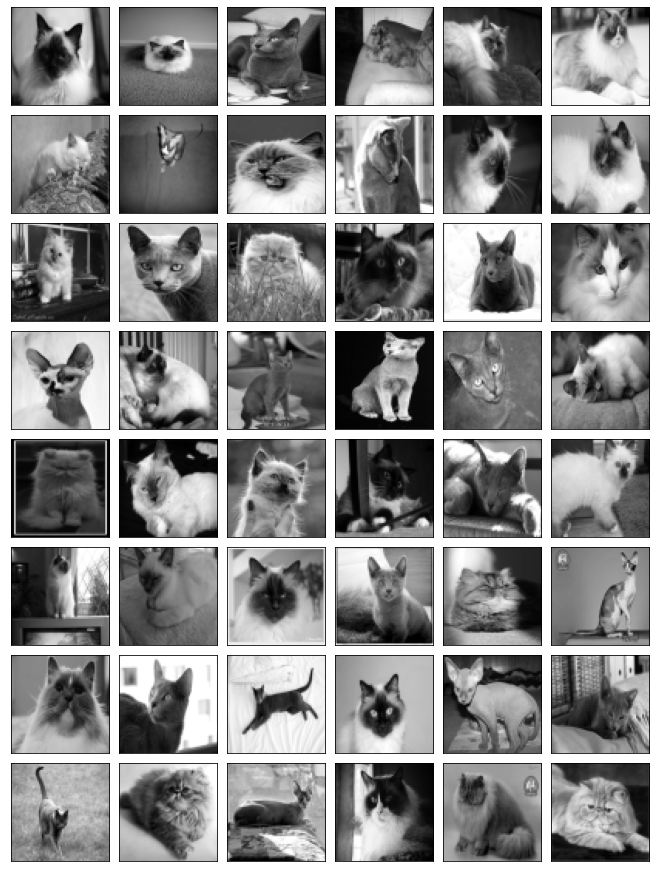


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training segmentation labels]



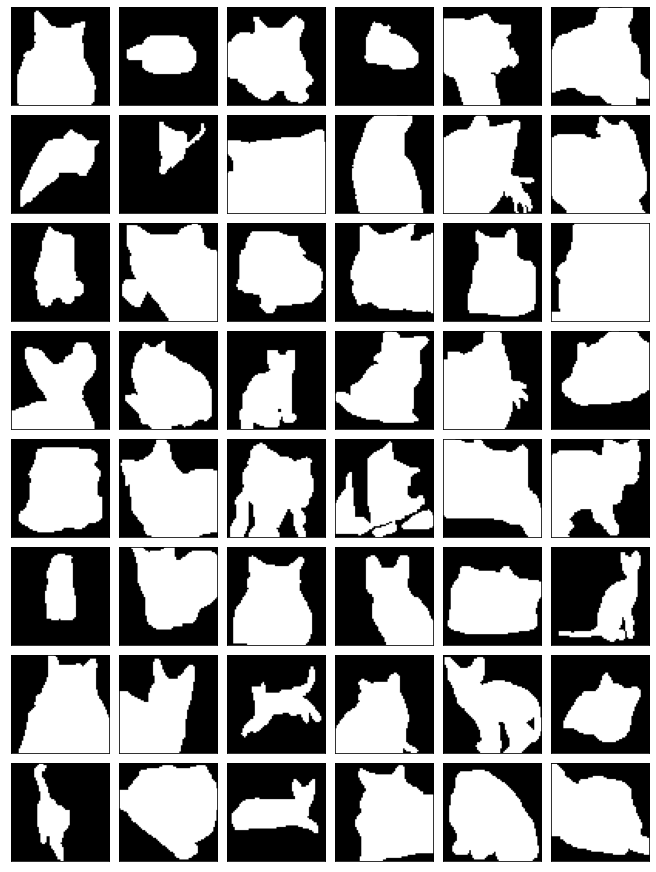


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



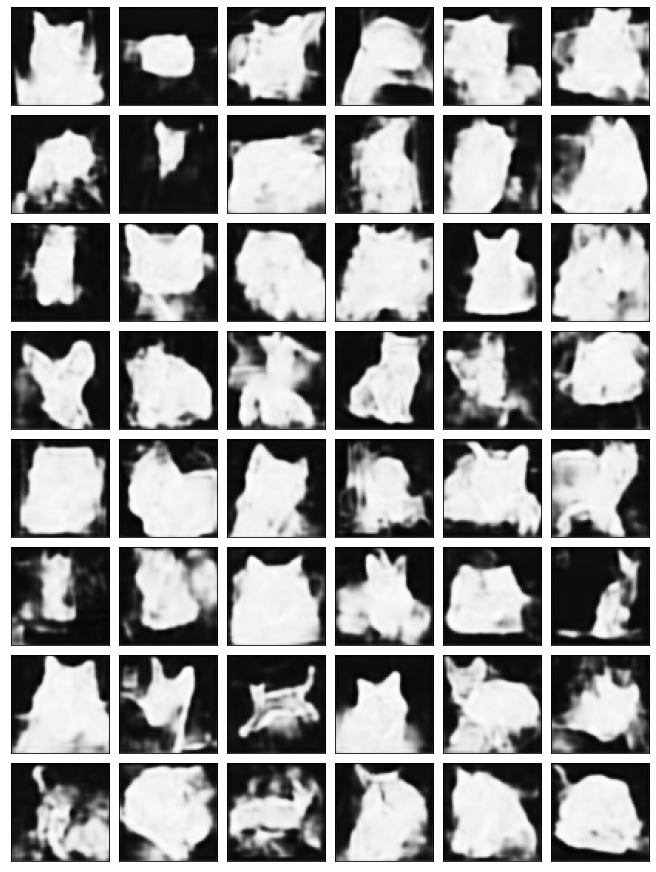


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing images]



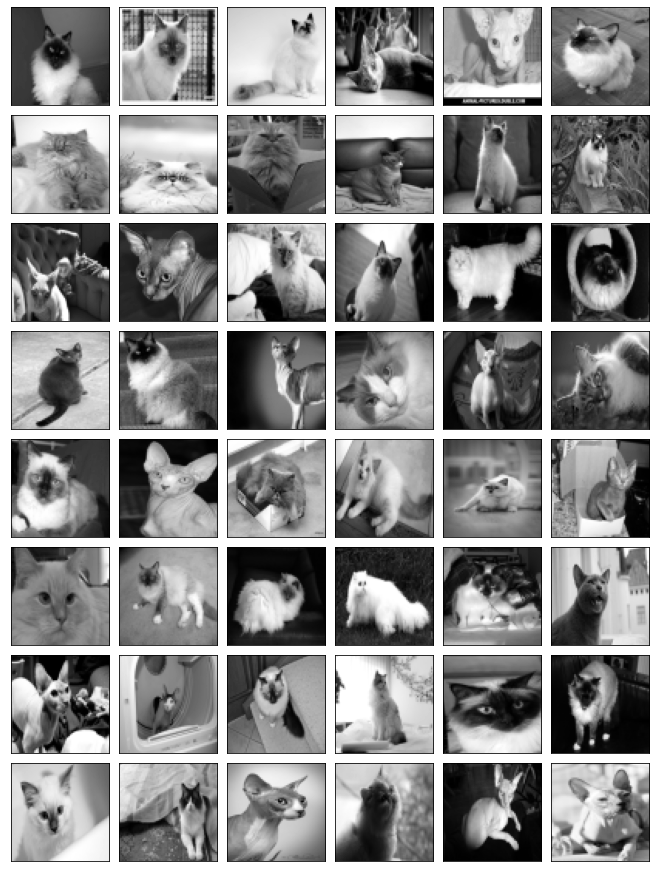


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing segmentation labels]



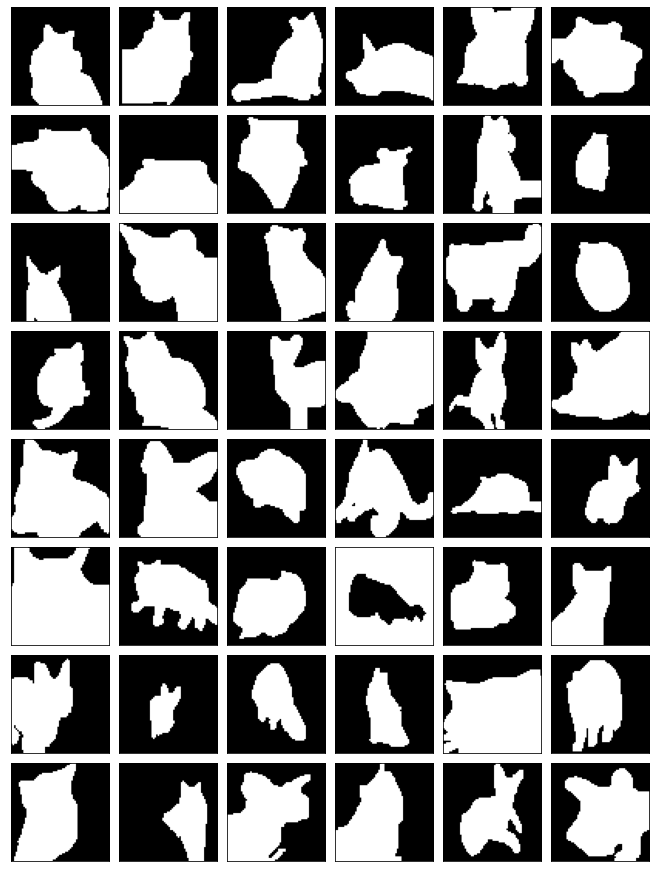


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



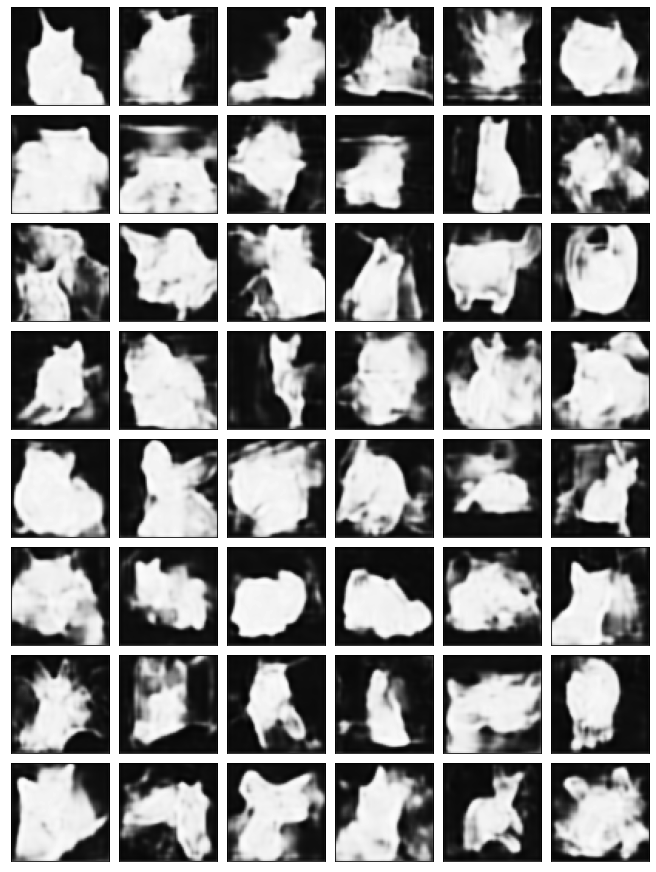


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



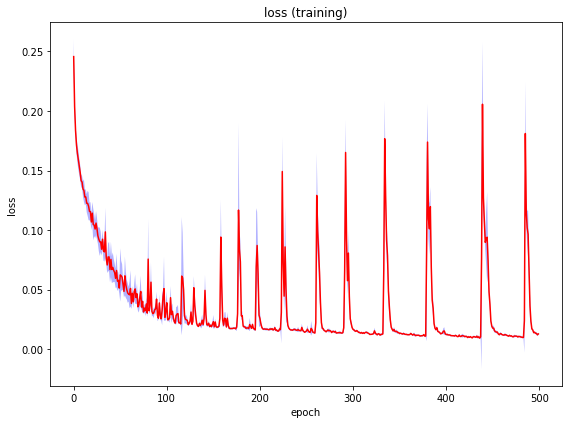


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



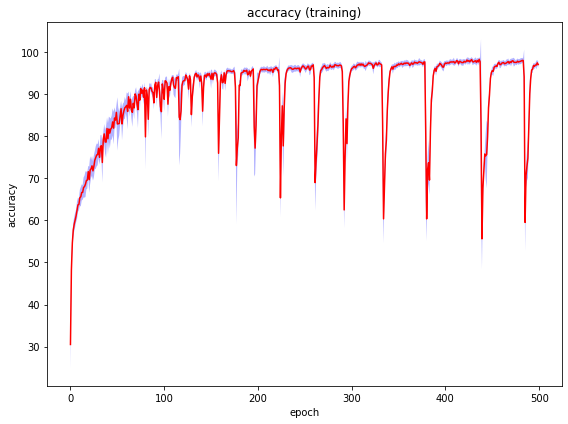


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



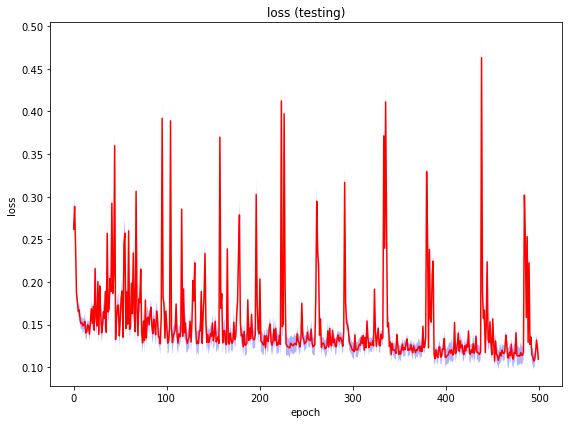


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



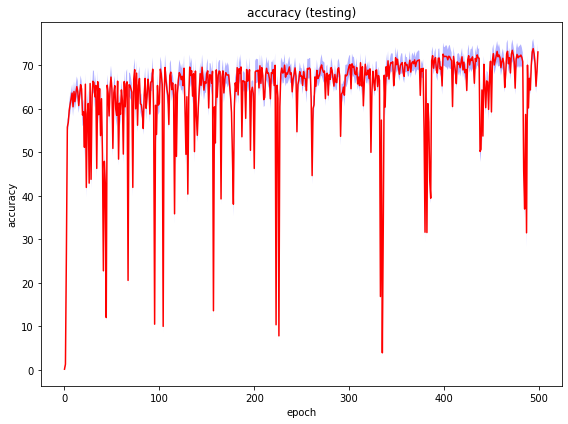


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0362798688
index =  1, value = 0.0233822724
index =  2, value = 0.0170509972
index =  3, value = 0.0160894024
index =  4, value = 0.0138496983
index =  5, value = 0.0141486211
index =  6, value = 0.0133086493
index =  7, value = 0.0131397184
index =  8, value = 0.0120383122
index =  9, value = 0.0127648843

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 90.0540444842
index =  1, value = 93.6996845234
index =  2, value = 95.6646578776
index =  3, value = 95.8531625013
index =  4, value = 96.7491522471
index =  5, value = 96.5679401687


In [72]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)